In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# 1)

In [91]:
def shifting(array,shift):
    N = len(array)
    array_ft = np.fft.fft(array)
    k = np.arange(N)
    phase_ramp = np.exp(-2*np.pi*1j*k*shift/N)
    shifted = np.fft.ifft(phase_ramp*array_ft)
    return shifted

In [116]:
x = np.linspace(0,10,1001)
std = 1
cent_gauss = np.exp(-0.5*(x-np.median(x))**2/std**2)

<IPython.core.display.Javascript object>


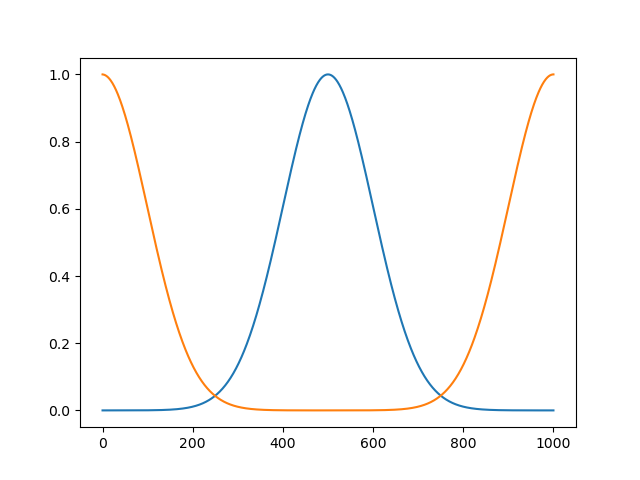

In [117]:
plt.figure()
plt.plot(np.abs(cent_gauss))
shifted_gauss = shifting(cent_gauss,len(cent_gauss)//2)
plt.plot(np.abs(shifted_gauss))

# 2)

## a)

In [120]:
def correlation(array1,array2):
    array1_ft, array2_ft = np.fft.fft(array1), np.fft.fft(array2)
    corr = np.fft.ifft(array1_ft*np.conj(array2_ft))
    return corr

<IPython.core.display.Javascript object>


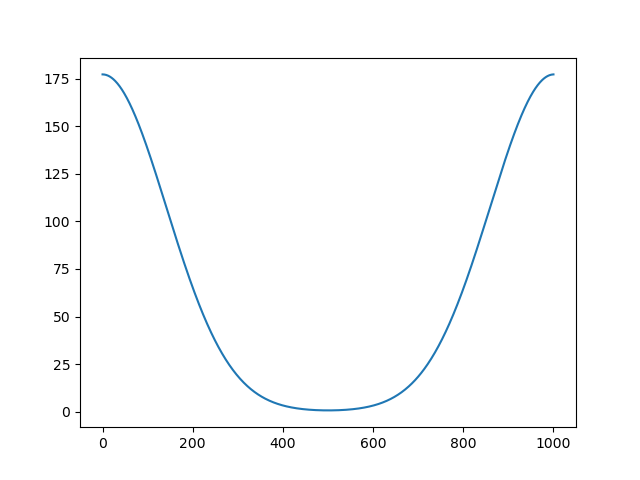

In [121]:
autocorr_gauss = correlation(cent_gauss,cent_gauss)
plt.figure()
plt.plot(np.abs(autocorr_gauss))

## b)

In [124]:
def corr_shifted_gaussian(gauss,shift):
    shifted_gauss = shifting(gauss,shift)
    corr = correlation(gauss,shifted_gauss)
    return corr

<IPython.core.display.Javascript object>


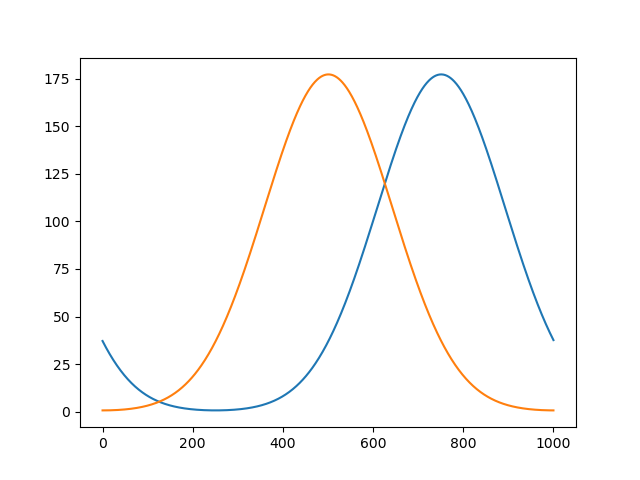

In [128]:
corr_gauss_shiftgauss_quarter = corr_shifted_gaussian(cent_gauss,len(cent_gauss)//4)
corr_gauss_shiftgauss_half = corr_shifted_gaussian(cent_gauss,len(cent_gauss)//2)
plt.figure()
plt.plot(np.abs(corr_gauss_shiftgauss_quarter), label = 'Correlation with gaussian shifted by 1/4 the array length')
plt.plot(np.abs(corr_gauss_shiftgauss_half), label = 'Correlation with gaussian shifted by 1/2 the array length')

# 3)

In [207]:
def convolution_nowrap(array1,array2):
    array1_w0s = np.hstack((array1,np.zeros(len(array1))))
    array2_w0s = np.hstack((np.zeros(len(array2)),array2))
    
    a1_ft,a2_ft = np.fft.fft(array1_w0s),np.fft.fft(array2_w0s)
    conv = np.fft.ifft(a1_ft*a2_ft)
    return conv[:len(conv)//2]

In [208]:
conv_test = convolution_nowrap(cent_gauss,cent_gauss)

<IPython.core.display.Javascript object>


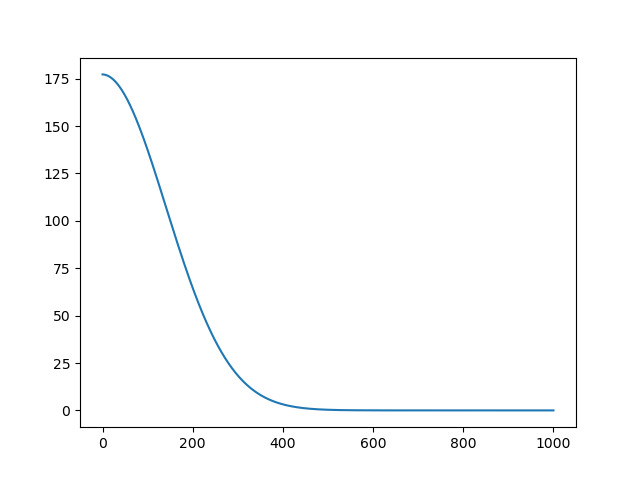

C:\Users\miara\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [209]:
plt.figure()
plt.plot(conv_test)

In [210]:
x = np.arange(1001)
square = np.zeros(1001)
square[3*len(square)//4:] = 1

triangle = np.zeros(len(square))
triangle[len(square)//4:3*len(square)//4] = x[len(square)//4]-x[len(square)//4:3*len(square)//4]
triangle = np.abs(triangle)
triangle/=np.max(triangle)
triangle = np.flip(triangle)

<IPython.core.display.Javascript object>


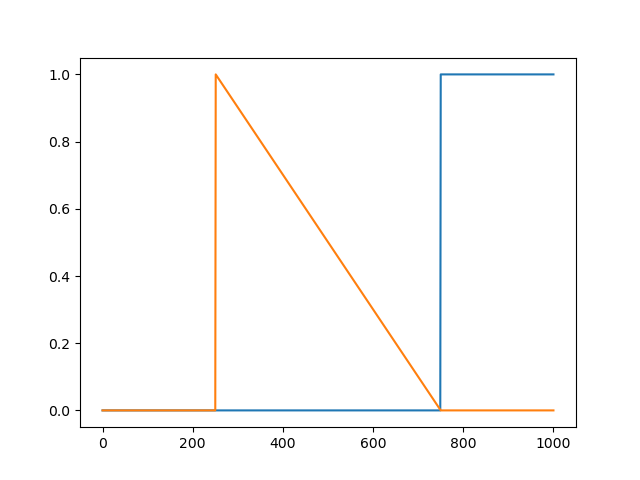

In [211]:
plt.figure()
plt.plot(square)
plt.plot(triangle)

In [212]:
conv_test = convolution_nowrap(square,triangle)

<IPython.core.display.Javascript object>


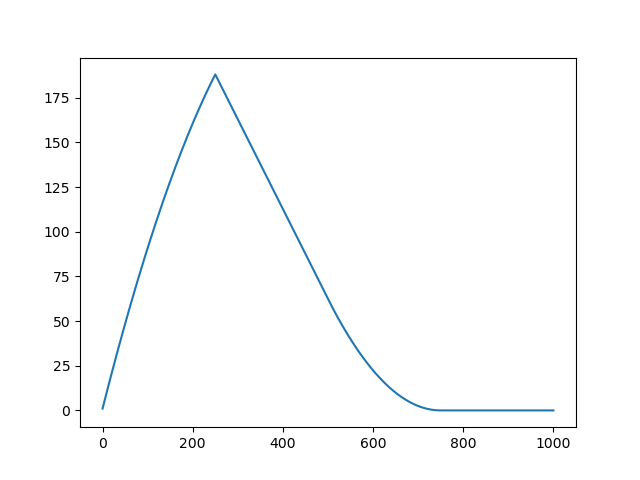

C:\Users\miara\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [213]:
plt.figure()
plt.plot(conv_test)

# 4)


In [360]:
def analytic_sin_dft(wvnum,N):
    k = np.arange(N)
    term1 = (1-np.exp(1j*(wvnum*N-2*np.pi*k)))/(1-np.exp(1j*(wvnum-2*np.pi/N*k)))
    term2 = np.conj(term1)
    return 1/(2j)*(term1-term2)

In [437]:
k = 3/2
N = 10001
analytic_dft = analytic_sin_dft(k,N)
x = np.arange(N)
y = np.sin(k*x)
yft = np.fft.fft(y)

<IPython.core.display.Javascript object>


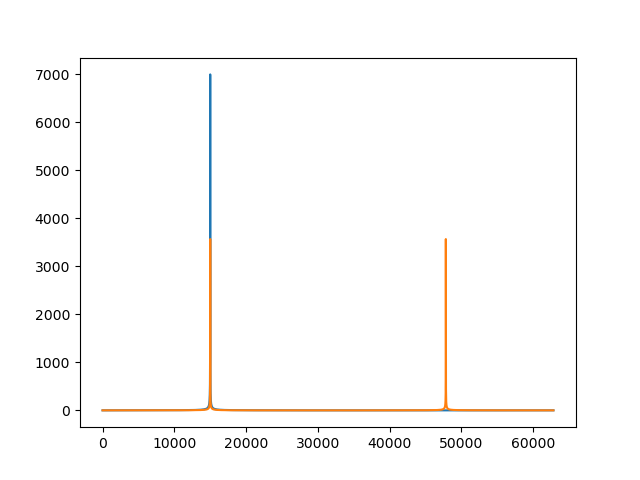

In [439]:
plt.figure()
plt.plot(2*np.pi*np.arange(N),np.abs(analytic_dft))
plt.plot(2*np.pi*np.arange(N),np.abs(yft))